# GauGAN
Credit: https://github.com/https-deeplearning-ai/GANs-Public

*Please note that this is meant to introduce more advanced concepts if you're up for a challenge, so don't worry if you don't completely follow!*

It is recommended that you should already be familiar with:
 - Pix2PixHD, from [High-Resolution Image Synthesis and Semantic Manipulation with Conditional GANs](https://arxiv.org/abs/1711.11585) (Wang et al. 2018)
 - Synchronized batch norm. See Pytorch's [SyncBatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.SyncBatchNorm.html) documentation.
 - Kullbach-Leibler divergence

### Goals

In this notebook, you will learn about GauGAN, which synthesizes high-resolution images from semantic label maps, which you implement and train. GauGAN is based around a special denormalization technique proposed in [Semantic Image Synthesis with Spatially-Adaptive Normalization](https://arxiv.org/abs/1903.07291) (Park et al. 2019)

### Background
GauGAN builds on Pix2PixHD but simplifies the overall network by adding spatially adaptive denormalization layers. Because it learns its denormalization parameters via convolving the instance segmentation map, it actually is better for multi-modal synthesis, since all it needs as is a random noise vector. Later in the notebook, you will see how the authors further control diversity with the noise vector.  

### Additional blog:
Checkout what GauGAN does at [NVIDIA](https://blogs.nvidia.com/blog/2019/03/18/gaugan-photorealistic-landscapes-nvidia-research/)

## GauGAN Submodules

Let's first take a look at the building blocks behind GauGAN.

### Synchronized BatchNorm

So you've already heard of batch norm, which is a normalization technique that tries to normalize the statistics of activations a standard Gaussian distribution.

Batch norm, however, performs poorly with small batch sizes. This becomes a problem when training large models that can only fit small batch sizes on GPUs. Training on multiple GPUs will increase the effective batch size, but vanilla batch norm will only update its statistics asynchronously on each GPU. Essentially, if you train on 2 gpus with `nn.BatchNorm2d`, the two batchnorm modules will have a different running averages of statistics and batch norm stability isn't better from larger effective batch size.

Synchronized batch norm ([nn.SyncBatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.SyncBatchNorm.html)) does exactly what its name suggests - it synchronizes batch norm running average updates across multiple processes so that each update will be with the statistics across all your minibatches.

The authors report slightly better scores with synchronized batch norm as opposed to regular (asynchronous) batch norm. Since you will likely be running this on one machine, this notebook will stick to regular `nn.BatchNorm2d` modules.

### Spatially Adaptive Denormalization (SPADE)

Recall that normalization layers are formulated as

\begin{align*}
    y &= \dfrac{x - \hat{\mu}}{\hat{\sigma}} * \gamma + \beta
\end{align*}

where $\hat{\mu}$ and $\hat{\sigma}$ correspond to an exponential moving average of minibatch means and standard deviations and are used to normalize the input activation $x$. The parameters $\gamma$ and $\beta$ apply "denormalization," essentially allowing the model to invert the normalization if necessary.

In GauGAN, batch norm is the preferred normalization scheme. Recall that batch norm can be formulated for each input neuron as

\begin{align*}
    y_{c,h,w} &= \dfrac{x_{c,h,w} - \hat{\mu}_c}{\hat{\sigma}_c} * \gamma_c + \beta_c
\end{align*}

where $\hat{\mu}_c$ and $\hat{\sigma}_c$ are per-channel statistics computed across the batch and spatial dimensions. Similarly, $\gamma_c$ and $\beta_c$ are per-channel denormalization parameters.

With vanilla batch norm, these denormalization parameters are spatially invariant - that is, the same values are applied to every position in the input activation. As you may imagine, this could be limiting for the model. Oftentimes it's conducive for the model to learn denormalization parameters for each position.

The authors address this with **SPatially Adaptive DEnormalization (SPADE)**. They compute denormalization parameters $\gamma$ and $\beta$ by convolving the input segmentation masks and apply these elementwise. SPADE can therefore be formulated as

\begin{align*}
    y_{c,h,w} &= \dfrac{x_{c,h,w} - \hat{\mu}_c}{\hat{\sigma}_c} * \gamma_{c,h,w} + \beta_{c,h,w}
\end{align*}

Now let's implement SPADE!

Note: the authors use spectral norm in all convolutional layers in the generator and discriminator, but the official code omits spectral norm for SPADE layers.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SPADE(nn.Module):
    '''
    SPADE Class
    Values:
        channels: the number of channels in the input, a scalar
        cond_channels: the number of channels in conditional input (one-hot semantic labels), a scalar
    '''

    def __init__(self, channels, cond_channels):
        super().__init__()

        self.batchnorm = nn.BatchNorm2d(channels)
        self.spade = nn.Sequential(
            nn.Conv2d(cond_channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, 2 * channels, kernel_size=3, padding=1),
        )

    def forward(self, x, seg):
        # Apply normalization
        x = self.batchnorm(x)

        # Compute denormalization
        seg = F.interpolate(seg, size=x.shape[-2:], mode='nearest')
        gamma, beta = torch.chunk(self.spade(seg), 2, dim=1)

        # Apply denormalization
        x = x * (1 + gamma) + beta
        return x

### Residual Blocks

Let's now implement residual blocks with SPADE normalization. You should be familiar with the residual block by now, but this implementation will be a bit different to accomodate for the extra semantic label map input. For a refresher on residual blocks, please take a look [here](https://paperswithcode.com/method/residual-block).

In [2]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class
    Values:
        in_channels: the number of input channels, a scalar
        out_channels: the number of output channels, a scalar
        cond_channels: the number of channels in conditional input in spade layer, a scalar
    '''

    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()

        hid_channels = min(in_channels, out_channels)

        self.proj = in_channels != out_channels
        if self.proj:
            self.norm0 = SPADE(in_channels, cond_channels)
            self.conv0 = nn.utils.spectral_norm(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            )

        self.activation = nn.LeakyReLU(0.2)
        self.norm1 = SPADE(in_channels, cond_channels)
        self.norm2 = SPADE(hid_channels, cond_channels)
        self.conv1 = nn.utils.spectral_norm(
            nn.Conv2d(in_channels, hid_channels, kernel_size=3, padding=1)
        )
        self.conv2 = nn.utils.spectral_norm(
            nn.Conv2d(hid_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, seg):
        dx = self.norm1(x, seg)
        dx = self.activation(dx)
        dx = self.conv1(dx)
        dx = self.norm2(dx, seg)
        dx = self.activation(dx)
        dx = self.conv2(dx)

        # Learn skip connection if in_channels != out_channels
        if self.proj:
            x = self.norm0(x, seg)
            x = self.conv0(x)

        return x + dx

## GauGAN Parts

Now that you understand the main contributions of GauGAN and its submodules, let's dive into the encoder, generator, and discriminator!

### Encoder

GauGAN's encoder serves a different purpose than Pix2PixHD's. Instead of learning feature maps to be fed as input to the generator, GauGAN's encoder encodes the original image into a mean and standard deviation from which to sample noise, which is given to the generator. You may recall this same technique of encoding to a mean and standard devation is used in variational autoencoders (VAEs, covered in a Course 2 optional notebook). 

In [3]:
class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
        spatial_size: tuple specifying (height, width) of full size image, a tuple
        z_dim: number of dimensions of latent noise vector (z), a scalar
        n_downsample: number of downsampling blocks in the encoder, a scalar
        base_channels: number of channels in the last hidden layer, a scalar
    '''

    max_channels = 512

    def __init__(self, spatial_size, z_dim=256, n_downsample=6, base_channels=64):
        super().__init__()

        layers = []
        channels = base_channels
        for i in range(n_downsample):
            in_channels = 3 if i == 0 else channels
            out_channels = 2 * z_dim if i < n_downsample else max(self.max_channels, channels * 2)
            layers += [
                nn.utils.spectral_norm(
                    nn.Conv2d(in_channels, out_channels, stride=2, kernel_size=3, padding=1)
                ),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            ]
            channels = out_channels

        h, w = spatial_size[0] // 2 ** n_downsample, spatial_size[1] // 2 ** n_downsample
        layers += [
            nn.Flatten(1),
            nn.Linear(channels * h * w, 2 * z_dim),
        ]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.chunk(self.layers(x), 2, dim=1)

### Generator

The GauGAN generator is actually very different from previous image-to-image translation generators. Because information from the semantic label map is injected at each batch normalization layer, the generator is able to just take random noise $z$ as input. This noise is reshaped and upsampled to the target image size.

Let's take a look at the implementation!

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        n_classes: the number of object classes in the dataset, a scalar
        bottom_width: the downsampled spatial size of the image, a scalar
        z_dim: the number of dimensions the z noise vector has, a scalar
        base_channels: the number of channels in last hidden layer, a scalar
        n_upsample: the number of upsampling operations to apply, a scalar
    '''

    max_channels = 1024

    def __init__(self, n_classes, spatial_size, z_dim=256, base_channels=64, n_upsample=6):
        super().__init__()

        h, w = spatial_size[0] // 2 ** n_upsample, spatial_size[1] // 2 ** n_upsample
        self.proj_z = nn.Linear(z_dim, self.max_channels * h * w)
        self.reshape = lambda x: torch.reshape(x, (-1, self.max_channels, h, w))

        self.upsample = nn.Upsample(scale_factor=2)
        self.res_blocks = nn.ModuleList()
        for i in reversed(range(n_upsample)):
            in_channels = min(self.max_channels, base_channels * 2 ** (i+1))
            out_channels = min(self.max_channels, base_channels * 2 ** i)
            self.res_blocks.append(ResidualBlock(in_channels, out_channels, n_classes))

        self.proj_o = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, seg):
        h = self.proj_z(z)
        h = self.reshape(h)
        for res_block in self.res_blocks:
            h = res_block(h, seg)
            h = self.upsample(h)
        h = self.proj_o(h)
        return h

### Discriminator

The architecture of the discriminator follows the one used in Pix2PixHD, which uses a multi-scale design with the InstanceNorm. The only difference here is that they apply spectral normalization to all convolutional layers. GauGAN's discriminator also takes as input the image concatenated with the semantic label map (no instance boundary map as in Pix2PixHD).

In [5]:
class PatchGANDiscriminator(nn.Module):
    '''
    PatchGANDiscriminator Class
    Implements the discriminator class for a subdiscriminator, 
    which can be used for all the different scales, just with different argument values.
    Values:
        in_channels: the number of channels in input, a scalar
        base_channels: the number of channels in first convolutional layer, a scalar
        n_layers: the number of convolutional layers, a scalar
    '''

    def __init__(self, in_channels, base_channels=64, n_layers=3):
        super().__init__()

        # Use nn.ModuleList so we can output intermediate values for loss.
        self.layers = nn.ModuleList()

        # Initial convolutional layer
        self.layers.append(
            nn.Sequential(
                nn.utils.spectral_norm(
                    nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=2)
                ),
                nn.LeakyReLU(0.2, inplace=True),
            )
        )

        # Downsampling convolutional layers
        channels = base_channels
        for _ in range(1, n_layers):
            prev_channels = channels
            channels = min(2 * channels, 512)
            self.layers.append(
                nn.Sequential(
                    nn.utils.spectral_norm(
                        nn.Conv2d(prev_channels, channels, kernel_size=4, stride=2, padding=2)
                    ),
                    nn.InstanceNorm2d(channels, affine=False),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )

        # Output convolutional layer
        prev_channels = channels
        channels = min(2 * channels, 512)
        self.layers.append(
            nn.Sequential(
                nn.utils.spectral_norm(
                    nn.Conv2d(prev_channels, channels, kernel_size=4, stride=1, padding=2))
                ,
                nn.InstanceNorm2d(channels, affine=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, 1, kernel_size=4, stride=1, padding=2)
                ),
            )
        )

    def forward(self, x):
        outputs = [] # for feature matching loss
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)

        return outputs

Now you're ready to implement the multiscale discriminator in full! This puts together the different subdiscriminator scales.

In [6]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        in_channels: number of input channels to each discriminator, a scalar
        base_channels: number of channels in last hidden layer, a scalar
        n_layers: number of downsampling layers in each discriminator, a scalar
        n_discriminators: number of discriminators at different scales, a scalar
    '''

    def __init__(self, in_channels, base_channels=64, n_layers=3, n_discriminators=3):
        super().__init__()

        # Initialize all discriminators
        self.discriminators = nn.ModuleList()
        for _ in range(n_discriminators):
            self.discriminators.append(
                PatchGANDiscriminator(in_channels, base_channels=base_channels, n_layers=n_layers)
            )

        # Downsampling layer to pass inputs between discriminators at different scales
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    def forward(self, x):
        outputs = []

        for i, discriminator in enumerate(self.discriminators):
            # Downsample input for subsequent discriminators
            if i != 0:
                x = self.downsample(x)

            outputs.append(discriminator(x))

        # Return list of multiscale discriminator outputs
        return outputs

    @property
    def n_discriminators(self):
        return len(self.discriminators)

## GauGAN: Putting it all together

You can now create your GauGAN model that encapsulates all the parts you've just learned about! Since the encoder outputs mean and log-variance values to sample random noise from, this implementation will use the 'reparameterization trick' to allow gradient flow to the encoder. If you're not familiar with this trick, it samples from $\mathcal{N}(0, I)$ and applies shift and scale ($\mu, \sigma$) as opposed to sampling directly from $\mathcal{N}(\mu, \sigma^2I)$:

\begin{align*}
    z: z \sim \mathcal{N}(\mu, \sigma^2I) \equiv \sigma * z + \mu: z \sim \mathcal{N}(0, I).
\end{align*}

In [7]:
class GauGAN(nn.Module):
    '''
    GauGAN Class
    Values:
        n_classes: number of object classes in dataset, a scalar
        spatial_size: tuple containing (height, width) of full-size image, a tuple
        base_channels: number of channels in last generator & first discriminator layers, a scalar
        z_dim: number of dimensions in noise vector (z), a scalar
        n_upsample: number of downsampling (encoder) and upsampling (generator) operations, a scalar
        n_disc_layer:: number of discriminator layers, a scalar
        n_disc: number of discriminators (at different scales), a scalar
    '''

    def __init__(
        self,
        n_classes,
        spatial_size,
        base_channels=64,
        z_dim=256,
        n_upsample=6,
        n_disc_layers=3,
        n_disc=3,
    ):
        super().__init__()

        self.encoder = Encoder(
            spatial_size, z_dim=z_dim, n_downsample=n_upsample, base_channels=base_channels,
        )
        self.generator = Generator(
            n_classes, spatial_size, z_dim=z_dim, base_channels=base_channels, n_upsample=n_upsample,
        )
        self.discriminator = Discriminator(
            n_classes + 3, base_channels=base_channels, n_layers=n_disc_layers, n_discriminators=n_disc,
        )

    def forward(self, x, seg):
        ''' Performs a full forward pass for training. '''
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        x_fake = self.generate(z, seg)
        pred = self.discriminate(x_fake, seg)
        return x_fake, pred

    def encode(self, x):
        return self.encoder(x)

    def generate(self, z, seg):
        ''' Generates fake image from noise vector and segmentation. '''
        return self.generator(z, seg)

    def discriminate(self, x, seg):
        ''' Predicts whether input image is real. '''
        return self.discriminator(torch.cat((x, seg), dim=1))

    @staticmethod
    def sample_z(mu, logvar):
        ''' Samples noise vector with reparameterization trick. '''
        eps = torch.randn(mu.size(), device=mu.device).to(mu.dtype)
        return (logvar / 2).exp() * eps + mu

    @property
    def n_disc(self):
        return self.discriminator.n_discriminators

## Loss Functions

GauGAN reuses the composite loss functions that Pix2PixHD does, except it replaces the LSGAN loss with [Hinge loss](https://paperswithcode.com/method/gan-hinge-loss). It also imposes a soft (0.05 weight) Kullbach-Leibler divergence (KLD) loss term on the Gaussian statistics generated by the encoder.

#### A debrief on KLD

KLD measures how different two probability distributions are. In the case of $\mathcal{N}(\mu, \sigma^2I)$ learned by the encoder, KLD loss encourages the learned distribution to be close to a standard Gaussian. For more information on implementation, check out Pytorch's [KLDivLoss](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html) documentation.

In [8]:
import torchvision.models as models

class VGG19(nn.Module):
    '''
    VGG19 Class
    Wrapper for pretrained torchvision.models.vgg19 to output intermediate feature maps
    '''

    def __init__(self):
        super().__init__()
        vgg_features = models.vgg19(pretrained=True).features

        self.f1 = nn.Sequential(*[vgg_features[x] for x in range(2)])
        self.f2 = nn.Sequential(*[vgg_features[x] for x in range(2, 7)])
        self.f3 = nn.Sequential(*[vgg_features[x] for x in range(7, 12)])
        self.f4 = nn.Sequential(*[vgg_features[x] for x in range(12, 21)])
        self.f5 = nn.Sequential(*[vgg_features[x] for x in range(21, 30)])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h1 = self.f1(x)
        h2 = self.f2(h1)
        h3 = self.f3(h2)
        h4 = self.f4(h3)
        h5 = self.f5(h4)
        return [h1, h2, h3, h4, h5]

class Loss(nn.Module):
    '''
    Loss Class
    Implements composite loss for GauGAN
    Values:
        lambda1: weight for feature matching loss, a float
        lambda2: weight for vgg perceptual loss, a float
        lambda3: weight for KLD loss, a float
        device: 'cuda' or 'cpu' for hardware to use
        norm_weight_to_one: whether to normalize weights to (0, 1], a bool
    '''

    def __init__(self, lambda1=10., lambda2=10., lambda3=0.05, device='cuda', norm_weight_to_one=True):
        super().__init__()

        self.vgg = VGG19().to(device)
        self.vgg_weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]

        lambda0 = 1.0
        # Keep ratio of composite loss, but scale down max to 1.0
        scale = max(lambda0, lambda1, lambda2, lambda3) if norm_weight_to_one else 1.0

        self.lambda0 = lambda0 / scale
        self.lambda1 = lambda1 / scale
        self.lambda2 = lambda2 / scale
        self.lambda3 = lambda3 / scale

    def kld_loss(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())

    def g_adv_loss(self, discriminator_preds):
        adv_loss = 0.0
        for preds in discriminator_preds:
            pred = preds[-1]
            adv_loss += -pred.mean()
        return adv_loss

    def d_adv_loss(self, discriminator_preds, is_real):
        adv_loss = 0.0
        for preds in discriminator_preds:
            pred = preds[-1]
            target = -1 + pred if is_real else -1 - pred
            mask = target < 0
            adv_loss += (mask * target).mean()
        return adv_loss

    def fm_loss(self, real_preds, fake_preds):
        fm_loss = 0.0
        for real_features, fake_features in zip(real_preds, fake_preds):
            for real_feature, fake_feature in zip(real_features, fake_features):
                fm_loss += F.l1_loss(real_feature.detach(), fake_feature)
        return fm_loss

    def vgg_loss(self, x_real, x_fake):
        vgg_real = self.vgg(x_real)
        vgg_fake = self.vgg(x_fake)

        vgg_loss = 0.0
        for real, fake, weight in zip(vgg_real, vgg_fake, self.vgg_weights):
            vgg_loss += weight * F.l1_loss(real.detach(), fake)
        return vgg_loss

    def forward(self, x_real, label_map, gaugan):
        '''
        Function that computes the forward pass and total loss for GauGAN.
        '''
        mu, logvar = gaugan.encode(x_real)
        z = gaugan.sample_z(mu, logvar)
        x_fake = gaugan.generate(z, label_map)

        # Get necessary outputs for loss/backprop for both generator and discriminator
        fake_preds_for_g = gaugan.discriminate(x_fake, label_map)
        fake_preds_for_d = gaugan.discriminate(x_fake.detach(), label_map)
        real_preds_for_d = gaugan.discriminate(x_real.detach(), label_map)

        g_loss = (
            self.lambda0 * self.g_adv_loss(fake_preds_for_g) + \
            self.lambda1 * self.fm_loss(real_preds_for_d, fake_preds_for_g) / gaugan.n_disc + \
            self.lambda2 * self.vgg_loss(x_fake, x_real) + \
            self.lambda3 * self.kld_loss(mu, logvar)
        )
        d_loss = 0.5 * (
            self.d_adv_loss(real_preds_for_d, True) + \
            self.d_adv_loss(fake_preds_for_d, False)
        )

        return g_loss, d_loss, x_fake.detach()

## Training GauGAN

You now have GauGAN implemented! All you have to do now is prepare your dataset. The authors trained GauGAN on a variety of datasets, but for simplicity, this notebook is geared towards the Cityscapes dataset (Pix2PixHD is also trained on the Cityscapes dataset). You'll have to download the dataset, unzip it, and put it in your `data` folder to initialize the dataset code below.

Specifically, you should download the `gtFine_trainvaltest` and `leftImg8bit_trainvaltest` and specify the corresponding data splits into the dataloader.

Below is a quick dataset class to help you load and preprocess the Cityscapes examples. You can also run the code below to download the dataset, after you've created an account at http://cityscapes-dataset.com.

In [9]:
# Store necessary cookies
import getpass, os
username = input("What is your Cityscapes username? (http://cityscapes-dataset.com) ")
password = getpass.getpass("What is your Cityscapes password? ")
os.mkdir("data")
os.system(f"wget --keep-session-cookies --save-cookies=data/cookies.txt --post-data 'username={username}&password={password}&submit=Login' https://www.cityscapes-dataset.com/login/")
# Download data
!cd data; wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
!cd data; wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
# Unzip data
!cd data; unzip leftImg8bit_trainvaltest
!cd data; unzip gtFine_trainvaltest

Streaming output truncated to the last 5000 lines.
  inflating: gtFine/test/berlin/berlin_000117_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000114_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000434_000019_gtFine_labelIds.png  
  inflating: gtFine/test/berlin/berlin_000420_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000483_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000420_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000254_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000490_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000448_000019_gtFine_polygons.json  
  inflating: gtFine/test/berlin/berlin_000099_000019_gtFine_labelIds.png  
  inflating: gtFine/test/berlin/berlin_000068_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000288_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000409_00001

In [10]:
import os

import numpy as np
import torchvision.transforms as transforms
from PIL import Image

class CityscapesDataset(torch.utils.data.Dataset):
    '''
    CityscapesDataset Class
    Values:
        paths: (a list of) paths to construct dataset from, a list or string
        img_size: tuple containing the (height, width) for resizing, a tuple
        n_classes: the number of object classes, a scalar
    '''

    def __init__(self, paths, img_size=(256, 512), n_classes=35):
        super().__init__()

        self.n_classes = n_classes

        # Collect list of examples
        self.examples = {}
        if type(paths) == str:
            self.load_examples_from_dir(paths)
        elif type(paths) == list:
            for path in paths:
                self.load_examples_from_dir(path)
        else:
            raise ValueError('`paths` should be a single path or list of paths')

        self.examples = list(self.examples.values())
        assert all(len(example) == 2 for example in self.examples)

        # Initialize transforms for the real color image
        self.img_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Initialize transforms for semantic label maps
        self.map_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
        ])

    def load_examples_from_dir(self, abs_path):
        '''
        Given a folder of examples, this function returns a list of paired examples.
        '''
        assert os.path.isdir(abs_path)

        img_suffix = '_leftImg8bit.png'
        label_suffix = '_gtFine_labelIds.png'

        for root, _, files in os.walk(abs_path):
            for f in files:
                if f.endswith(img_suffix):
                    prefix = f[:-len(img_suffix)]
                    attr = 'orig_img'
                elif f.endswith(label_suffix):
                    prefix = f[:-len(label_suffix)]
                    attr = 'label_map'
                else:
                    continue

                if prefix not in self.examples.keys():
                    self.examples[prefix] = {}
                self.examples[prefix][attr] = root + '/' + f

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Load image and maps
        img = Image.open(example['orig_img']).convert('RGB') # color image: (3, h, w)
        label = Image.open(example['label_map'])             # semantic label map: (1, h, w)

        # Apply corresponding transforms
        img = self.img_transforms(img)
        label = self.map_transforms(label).long() * 255

        # Convert labels to one-hot vectors
        label = F.one_hot(label, num_classes=self.n_classes)
        label = label.squeeze(0).permute(2, 0, 1).to(img.dtype)

        return (img, label)

    def __len__(self):
        return len(self.examples)

    @staticmethod
    def collate_fn(batch):
        imgs, labels = [], []
        for (x, l) in batch:
            imgs.append(x)
            labels.append(l)
        return torch.stack(imgs, dim=0), torch.stack(labels, dim=0)

Now initialize everything you'll need for training. Don't be worried if there looks like a lot of random code, it's all stuff you've seen before!

In [11]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def lr_lambda(epoch):
    ''' Function for scheduling learning rate '''
    return 1. if epoch < decay_after else 1 - float(epoch - decay_after) / (epochs - decay_after)

def weights_init(m):
    ''' Function for initializing all model weights '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weights_init)

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gaugan_config = {
    'n_classes': 35,
    'spatial_size': (128, 256), # Default (256, 512): halve size for memory
    'base_channels': 32,        # Default 64: halve channels for memory
    'z_dim': 256,
    'n_upsample': 5,            # Default 6: decrease layers for memory
    'n_disc_layers': 2,
    'n_disc': 3,
}
gaugan = GauGAN(**gaugan_config).to(device)
loss = Loss(device=device)

# Initialize dataloader
train_dir = ['data']
batch_size = 16                 # Default 32: decrease for memory
dataset = CityscapesDataset(
    train_dir, img_size=gaugan_config['spatial_size'], n_classes=gaugan_config['n_classes'],
)
dataloader = DataLoader(
    dataset, collate_fn=CityscapesDataset.collate_fn,
    batch_size=batch_size, shuffle=True,
    drop_last=False, pin_memory=True,
)

# Initialize optimizers + schedulers
epochs = 200                    # total number of train epochs
decay_after = 100               # number of epochs with constant lr
betas = (0.0, 0.999)

g_params = list(gaugan.generator.parameters()) + list(gaugan.encoder.parameters())
d_params = list(gaugan.discriminator.parameters())

g_optimizer = torch.optim.Adam(g_params, lr=1e-4, betas=betas)
d_optimizer = torch.optim.Adam(d_params, lr=4e-4, betas=betas)
g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lr_lambda)
d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

And now the training loop, which is pretty much the same between the two phases:

 32%|███▏      | 100/313 [08:51<19:13,  5.41s/it]

Step 100: Generator loss: 12.13167, Discriminator loss: -26.74988


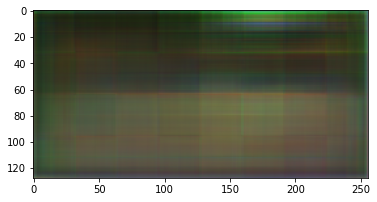

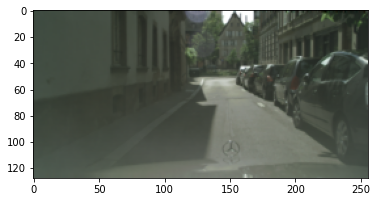

 64%|██████▍   | 200/313 [17:50<10:02,  5.34s/it]

Step 200: Generator loss: 10.69057, Discriminator loss: -32.40969


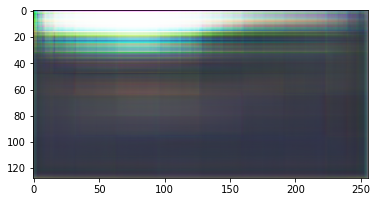

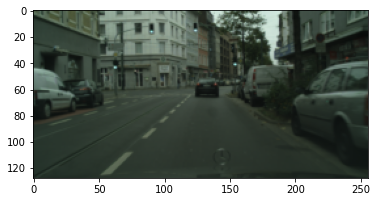

 96%|█████████▌| 300/313 [26:48<01:09,  5.36s/it]

Step 300: Generator loss: 10.35198, Discriminator loss: -32.56609


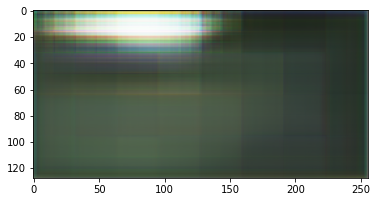

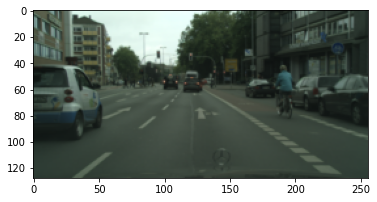

 28%|██▊       | 87/313 [07:44<20:09,  5.35s/it]

Step 400: Generator loss: 10.24815, Discriminator loss: -32.74781


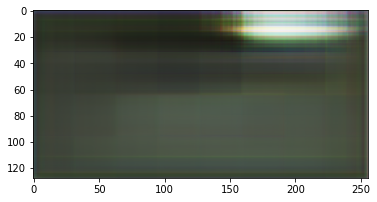

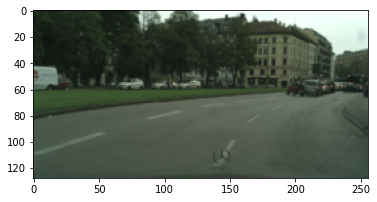

 60%|█████▉    | 187/313 [16:50<11:18,  5.39s/it]

Step 500: Generator loss: 10.13577, Discriminator loss: -32.81531


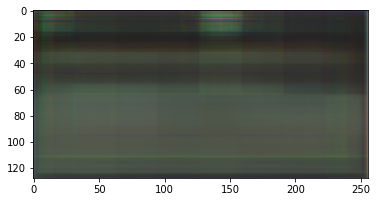

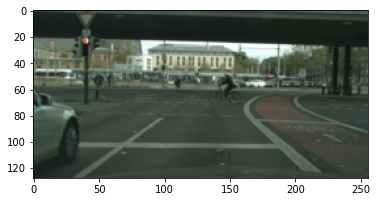

 92%|█████████▏| 287/313 [25:48<02:19,  5.37s/it]

Step 600: Generator loss: 9.92083, Discriminator loss: -32.89969


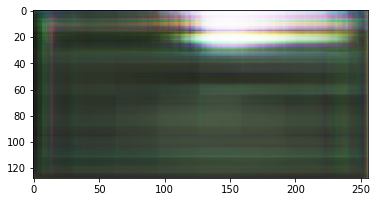

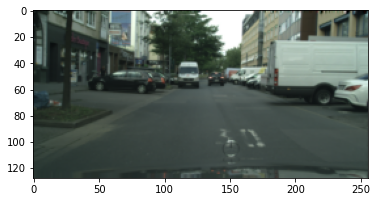

 24%|██▎       | 74/313 [06:41<21:18,  5.35s/it]

Step 700: Generator loss: 9.86529, Discriminator loss: -32.94969


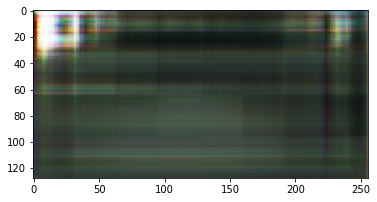

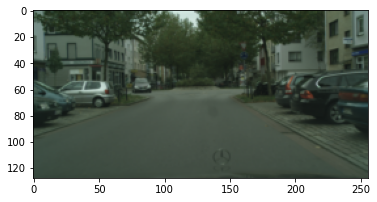

 25%|██▌       | 79/313 [07:09<20:57,  5.38s/it]

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Parse torch version for autocast
# #################################################
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)
# #################################################

def show_tensor_images(image_tensor):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:1], nrow=1)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def train(dataloader, gaugan, optimizers, schedulers, device):
    g_optimizer, d_optimizer = optimizers
    g_scheduler, d_scheduler = schedulers

    cur_step = 0
    display_step = 100

    mean_g_loss = 0.0
    mean_d_loss = 0.0

    for epoch in range(epochs):
        # Training epoch
        for (x_real, labels) in tqdm(dataloader, position=0):
            x_real = x_real.to(device)
            labels = labels.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    g_loss, d_loss, x_fake = loss(x_real, labels, gaugan)
            else:
                g_loss, d_loss, x_fake = loss(x_real, labels, gaugan)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: Generator loss: {:.5f}, Discriminator loss: {:.5f}'
                      .format(cur_step, mean_g_loss, mean_d_loss))
                show_tensor_images(x_fake.to(x_real.dtype))
                show_tensor_images(x_real)
                mean_g_loss = 0.0
                mean_d_loss = 0.0
            cur_step += 1

        g_scheduler.step()
        d_scheduler.step()

train(
    dataloader, gaugan,
    [g_optimizer, d_optimizer],
    [g_scheduler, d_scheduler],
    device,
)